## Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

import os
for file in os.listdir("../input"):
    print(file)

imdb-spoiler-dataset


### Set some matplotlib configs for visualization

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [3]:
# Read the dataset
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

## Function to get a equal number of data.


In [4]:
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

In [5]:
data = get_part_data(df_reviews,20000)
all_reviews = np.array(data.review_text)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 40000


## Preprocess the text

In [6]:
def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    
    # 2. Remove non-letters
    letters_only = REPLACE_WITH_SPACE.sub(" ", review_text)
    
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    
    return lemmas

In [7]:
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

In [8]:
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

In [9]:
train_data = data
X_train_data = all_reviews
Y_train_data = train_data.is_spoiler.values

In [10]:
%%time
bigrams = Phrases(sentences=all_reviews)

CPU times: user 10.2 s, sys: 87.3 ms, total: 10.3 s
Wall time: 10.3 s


In [11]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

CPU times: user 27 s, sys: 166 ms, total: 27.1 s
Wall time: 27.2 s


## Now we can use gensim's phrases to find bigrams or trigrams

In [12]:
print(bigrams['space station near the solar system'.split()])

['space_station', 'near', 'the', 'solar_system']


In [13]:
%%time
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    vector_size = embedding_vector_size,
    min_count=3, window=5, workers=4)

CPU times: user 5min 29s, sys: 664 ms, total: 5min 29s
Wall time: 4min 19s


In [14]:
print("Vocabulary size:", len(trigrams_model.wv.key_to_index))

Vocabulary size: 51479


### word2vec model to define most similar words, calculate diffence between the words, etc.

In [15]:
trigrams_model.wv.most_similar('galaxy')

[('planet', 0.8828447461128235),
 ('wormhole', 0.8583532571792603),
 ('black_hole', 0.8545237183570862),
 ('federation', 0.8488337993621826),
 ('space_station', 0.8487983345985413),
 ('krypton', 0.8454557657241821),
 ('vulcan', 0.8404152393341064),
 ('mar', 0.8391168713569641),
 ('portal', 0.8333704471588135),
 ('colony', 0.8319793939590454)]

In [16]:
trigrams_model.wv.doesnt_match(['galaxy', 'starship', 'planet', 'dog'])

'dog'

## Gensim's word2vec model to build a word embedding

In [17]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.key_to_index),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 7min 34s, sys: 586 ms, total: 7min 35s
Wall time: 7min 36s


## Train and test split to padded sequence

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    Y_train_data,
    test_size=0.2,
    shuffle=True,
    random_state=42)

In [19]:
X_train = np.asarray(X_train).astype(np.int)

y_train = np.asarray(y_train).astype(np.int)

X_test = np.asarray(X_test).astype(np.int)

y_test = np.asarray(y_test).astype(np.int)

## Bi-LSTM Model

In [20]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

2022-03-19 20:18:34.657062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 20:18:34.842757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 20:18:34.843502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 20:18:34.845454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 256)          13178624  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,589,377
Trainable params: 410,753
Non-trainable params: 13,178,624
______________________________________

In [21]:
 model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=10)

Epoch 1/10


2022-03-19 20:18:36.993472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1000/1000 [==============================] - 439s 435ms/step - loss: 0.6377 - accuracy: 0.6414 - val_loss: 0.6084 - val_accuracy: 0.6685
Epoch 2/10
1000/1000 [==============================] - 435s 435ms/step - loss: 0.6049 - accuracy: 0.6743 - val_loss: 0.5953 - val_accuracy: 0.6815
Epoch 3/10
1000/1000 [==============================] - 435s 435ms/step - loss: 0.5907 - accuracy: 0.6855 - val_loss: 0.5954 - val_accuracy: 0.6760
Epoch 4/10
1000/1000 [==============================] - 435s 435ms/step - loss: 0.5747 - accuracy: 0.6963 - val_loss: 0.5946 - val_accuracy: 0.6766
Epoch 5/10
1000/1000 [==============================] - 437s 437ms/step - loss: 0.5593 - accuracy: 0.7118 - val_loss: 0.5930 - val_accuracy: 0.6785
Epoch 6/10
1000/1000 [==============================] - 438s 438ms/step - loss: 0.5364 - accuracy: 0.7273 - val_loss: 0.6039 - val_accuracy: 0.6727
Epoch 7/10
1000/1000 [==============================] - 440s 440ms/step - loss: 0.5023 - accuracy: 0.7513 - val_loss: 0.636

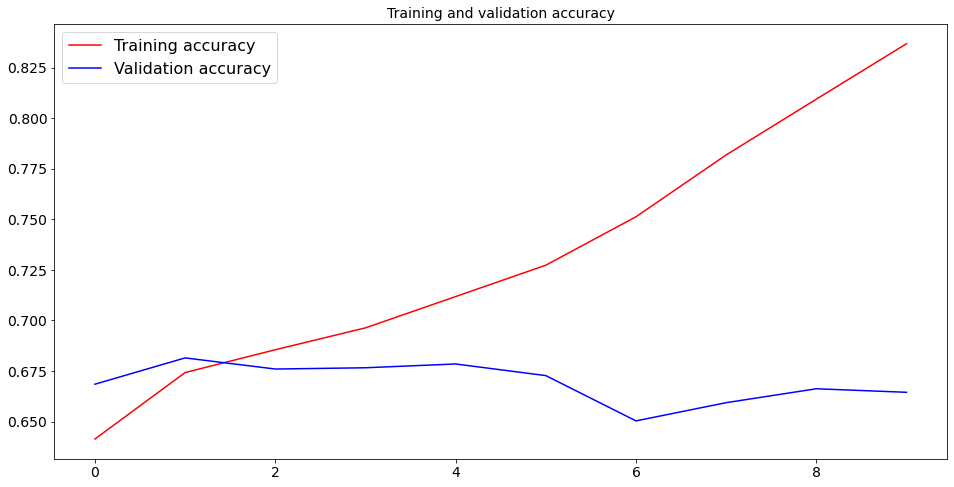

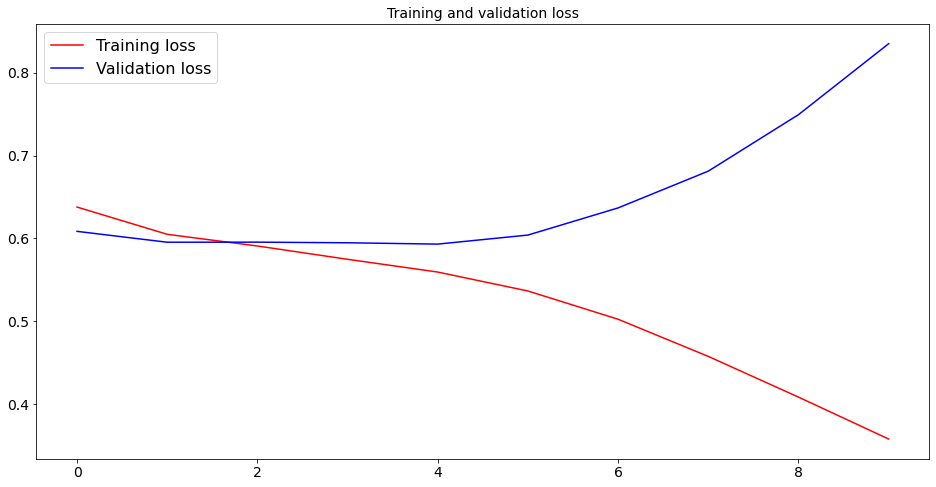

In [22]:
# Evaluate the model using accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()


### Evaluation Report

In [23]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import classification_report
report = classification_report(y_test,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.69      0.67      3986
           1       0.68      0.63      0.66      4014

    accuracy                           0.66      8000
   macro avg       0.67      0.66      0.66      8000
weighted avg       0.67      0.66      0.66      8000



### AUC score for the Word2vec embedding using BI-LStm Model¶

In [24]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, predictions ))

0.6646043914037947
